In [126]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib

In [ ]:
# ###########################
# import data
# ###########################

In [ ]:
# import crash data
crashes_raw = gpd.read_file('https://opendata.arcgis.com/datasets/70392a096a8e431381f1f692aaa06afd_24.geojson')

In [ ]:
# import anc data
ancs = gpd.read_file('https://opendata.arcgis.com/datasets/fcfbf29074e549d8aff9b9c708179291_1.geojson')

In [ ]:
# import all address points
address_points = gpd.read_file('https://opendata.arcgis.com/datasets/aa514416aaf74fdc94748f1e56e7cc8a_0.geojson')

In [ ]:
# import census blocks
census_blocks = gpd.read_file('https://opendata.arcgis.com/datasets/a6f76663621548e1a039798784b64f10_0.geojson')

In [ ]:
# import vision zero safety requests
vision_zero = gpd.read_file('https://opendata.arcgis.com/datasets/3f28bc3ad77f49079efee0ac05d8464c_0.geojson')

In [ ]:
# 311 data
# import all 311 service requests in 2020
all311_2020 = gpd.read_file('https://opendata.arcgis.com/datasets/82b33f4833284e07997da71d1ca7b1ba_11.geojson')
# 2019
all311_2019 = gpd.read_file('https://opendata.arcgis.com/datasets/98b7406def094fa59838f14beb1b8c81_10.geojson')
# 2018
all311_2018 = gpd.read_file('https://opendata.arcgis.com/datasets/2a46f1f1aad04940b83e75e744eb3b09_9.geojson')
# 2017
all311_2017 = gpd.read_file('https://opendata.arcgis.com/datasets/19905e2b0e1140ec9ce8437776feb595_8.geojson')
# 2016
all311_2016 = gpd.read_file('https://opendata.arcgis.com/datasets/0e4b7d3a83b94a178b3d1f015db901ee_7.geojson')
# 2015
all311_2015 = gpd.read_file('https://opendata.arcgis.com/datasets/b93ec7fc97734265a2da7da341f1bba2_6.geojson')

In [ ]:
# limit all the 311 requests to just traffic safety assessments, and merge them
tsa = all311_2020[all311_2020['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation']
print('2020: ', len(tsa))
tsa = tsa.append(all311_2019[all311_2019['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019: ', len(tsa))
tsa = tsa.append(all311_2018[all311_2018['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018: ', len(tsa))
tsa = tsa.append(all311_2017[all311_2017['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017: ', len(tsa))
tsa = tsa.append(all311_2016[all311_2016['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017 + 2016: ', len(tsa))
tsa = tsa.append(all311_2015[all311_2015['SERVICECODEDESCRIPTION'] == 'Traffic Safety Investigation'], ignore_index=True)
print('2020 + 2019 + 2018 + 2017 + 2016 + 2015: ', len(tsa))

In [ ]:
#######################################
# merge census block into all datasets
#######################################

In [ ]:
# CRASHES
# join crashes to data natively at census block level and add year
# do both right and left joins
# first add year
crashes_raw['YEAR'] = crashes_raw.apply(lambda x: x.REPORTDATE[:4], axis=1)
census_blocks_crashes = gpd.sjoin(crashes_raw, census_blocks, how="left", op='intersects')
# census_blocks_crashes_right = gpd.sjoin(crashes_raw, census_blocks, how="right", op='intersects')

In [ ]:
for column in census_blocks_crashes.columns:
    print(column)

In [ ]:
# how many crashes didn't join to a census block
# crashes_null=census_blocks_crashes[(census_blocks_crashes['OBJECTID_right'].isnull()) & (census_blocks_crashes['YEAR'] == '2020')]
crashes_null=census_blocks_crashes[(census_blocks_crashes['OBJECTID_right'].isnull())]

In [ ]:
len(census_blocks_crashes)

In [ ]:
len(crashes_null)

In [ ]:
# export null crashes to a csv file so i can check it out in a db
crashes_null.to_csv('data/no_census_blocks/crashes_not_joining_to_census_block.csv')

In [ ]:
# TRAFFIC SAFETY ASSESSMENT REQUESTS
for column in tsa.columns:
    print(column)

In [ ]:
# add year
tsa['YEAR'] = tsa.apply(lambda x: x.ADDDATE[:4], axis=1)

In [ ]:
tsa.head()

In [ ]:
census_blocks_tsas = gpd.sjoin(tsa, census_blocks, how="left", op='intersects')

In [ ]:
# how many TSAs didn't join to a census block
census_blocks_tsas_null=census_blocks_tsas[(census_blocks_tsas['OBJECTID_right'].isnull())]

In [ ]:
len(census_blocks_tsas)

In [ ]:
len(census_blocks_tsas_null)

In [ ]:
# export null TSAs to a csv file so i can check it out in a db
census_blocks_tsas_null.to_csv('data/no_census_blocks/TSAs_not_joining_to_census_block.csv')

In [ ]:
# VISION ZERO REQUESTS
# first add year
for column in vision_zero.columns:
    print(column)

In [ ]:
vision_zero['YEAR'] = vision_zero.apply(lambda x: x.REQUESTDATE[:4], axis=1)

In [ ]:
census_blocks_vision_zero = gpd.sjoin(vision_zero, census_blocks, how="left", op='within')

In [ ]:
# how many vision zero requests didn't roll up to a census block
census_blocks_vision_zero_null=census_blocks_vision_zero[(census_blocks_vision_zero['OBJECTID_right'].isnull())]

In [ ]:
len(census_blocks_vision_zero)

In [ ]:
len(census_blocks_vision_zero_null)

In [ ]:
# export null records to a csv file so i can check it out in a db
census_blocks_vision_zero_null.to_csv('data/no_census_blocks/VZ_Requests_not_joining_to_census_block.csv')

In [ ]:
#######################################
# roll up by census block and year
# Merge
# Join back to census block dataset to get a geometry
#######################################

In [ ]:
# Crashes data
census_blocks_crashes['PED_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_PEDESTRIAN','MINORINJURIES_PEDESTRIAN','UNKNOWNINJURIES_PEDESTRIAN'}].sum(axis=1)
census_blocks_crashes['BICYCLE_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_BICYCLIST','MINORINJURIES_BICYCLIST','UNKNOWNINJURIES_BICYCLIST'}].sum(axis=1)
census_blocks_crashes['VEHICLE_INJURIES']=census_blocks_crashes[{'MAJORINJURIES_DRIVER','MINORINJURIES_DRIVER','UNKNOWNINJURIES_DRIVER','MAJORINJURIESPASSENGER','MINORINJURIESPASSENGER','UNKNOWNINJURIESPASSENGER'}].sum(axis=1)

In [ ]:
census_blocks_crashes.head()

In [ ]:
census_blocks_crashes['TOTAL_INJURIES']=census_blocks_crashes[{'PED_INJURIES','BICYCLE_INJURIES','VEHICLE_INJURIES'}].sum(axis=1)
census_blocks_crashes['TOTAL_FATALITIES']=census_blocks_crashes[{'FATAL_DRIVER','FATAL_BICYCLIST','FATAL_PEDESTRIAN','FATALPASSENGER'}].sum(axis=1)

In [ ]:
crashes_agg = (census_blocks_crashes.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count', 'PED_INJURIES': 'sum', 'BICYCLE_INJURIES': 'sum','VEHICLE_INJURIES': 'sum','TOTAL_INJURIES': 'sum','TOTAL_FATALITIES': 'sum'})
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_CRASHES'}))

In [ ]:
crashes_agg.head(20)

In [ ]:
len(crashes_agg)

In [ ]:
# TSA data

In [ ]:
census_blocks_tsas_agg = (census_blocks_tsas.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count'})
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_TSA_REQUESTS'}))

In [ ]:
census_blocks_tsas_agg.head(20)

In [ ]:
len(census_blocks_tsas_agg)

In [ ]:
crashes_tsas_agg = crashes_agg.merge(census_blocks_tsas_agg, how = 'left', on=['OBJECTID_right', 'YEAR'])

In [ ]:
len(crashes_tsas_agg)

In [ ]:
crashes_tsas_agg.head(20)

In [ ]:
# vision zero data
census_blocks_vision_zero_agg = (census_blocks_vision_zero.groupby(['OBJECTID_right', 'YEAR'])
               .agg({'OBJECTID_left':'count'})
               .reset_index().rename(columns={'OBJECTID_left':'TOTAL_VISION_ZERO_REQUESTS'}))

In [ ]:
crashes_tsas_vz_agg = crashes_tsas_agg.merge(census_blocks_vision_zero_agg, how = 'left', on=['OBJECTID_right', 'YEAR'])

In [ ]:
crashes_tsas_vz_agg.head(20)

In [107]:
len(crashes_tsas_vz_agg)

49249

In [111]:
geo_info = crashes_tsas_agg.merge(census_blocks, how = 'inner', left_on = 'OBJECTID_right', right_on = 'OBJECTID')

In [112]:
len(geo_info)

49249

In [116]:
geo_info.geometry.name

'geometry'

In [121]:
geo_info = geo_info.set_geometry('geometry')

In [122]:
geo_info['geometry'].geom_type

0        Polygon
1        Polygon
2        Polygon
3        Polygon
4        Polygon
          ...   
49244    Polygon
49245    Polygon
49246    Polygon
49247    Polygon
49248    Polygon
Length: 49249, dtype: object

In [ ]:
# census_blocks_addr = gpd.sjoin(address_points, census_blocks, how="left", op='within')

In [114]:
# roll up address points to census block, keeping one representative row for each census block
census_blocks_addr = address_points.dissolve(by='CENSUS_BLOCK', aggfunc='first')

In [130]:
final = gpd.sjoin(geo_info, census_blocks_addr, how="left", op='intersects')

In [131]:
len(final)

49263

In [133]:
# how many vision zero requests didn't roll up to a census block
final_null=final[(final['WARD'].isnull())]

In [134]:
final_null.to_csv('data/no_census_blocks/census_blocks_w_crash_stats_not_joining_to_address.csv')

<AxesSubplot:>

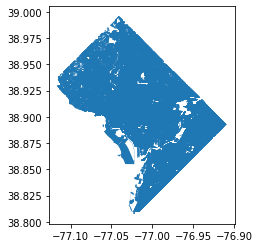

In [128]:
final.plot()

<AxesSubplot:>

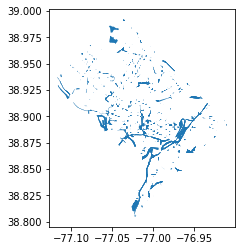

In [135]:
final_null.plot()

In [ ]:
final.head(20)

In [136]:
final.to_csv('data/merged/merged_v1.csv')

In [143]:
final_2020 = final[final['YEAR'] == '2020']

In [144]:
final_2020.to_file("data/merged/merged_v1_2020.geojson", driver='GeoJSON')

In [ ]:
#######################################
# OLD CODE
# keeping it to refer back to
#######################################

In [ ]:
# join crashes to data natively at ANC level and add year
anc_crashes = gpd.sjoin(crashes_raw, ancs, how="inner", op='within')
anc_crashes['YEAR'] = anc_crashes.apply(lambda x: x.REPORTDATE[:4], axis=1)
#Number of crashes thus far in 2020 by ANC
pd.DataFrame(anc_crashes.groupby(['YEAR', 'NAME']).size()).loc['2020']

In [ ]:
# try to roll up address points to desired level
# roll up address points to census block 
census_blocks = address_points.dissolve(by='CENSUS_BLOCK', aggfunc='first')

In [ ]:
census_blocks.head()

In [ ]:
# check geo type
census_blocks['geometry'].geom_type

In [ ]:
len(census_blocks)

In [ ]:
# remove points so census blocks can be rolled up to polygons
census_blocks=census_blocks[census_blocks['geometry'].geom_type != 'Point']

In [ ]:
# check how many fell out
len(census_blocks)

In [ ]:
# limit the census blocks dataset to census blocks that can become polygons
census_blocks = census_blocks[census_blocks['geometry'].apply(lambda x: len(list(x)) > 2)]

In [ ]:
len(census_blocks)

In [ ]:
census_block_polygons=census_blocks.copy()

In [ ]:
# convert to polygons
census_block_polygons['geometry'] = census_block_polygons.apply(lambda x: Polygon(x.geometry), axis=1)

In [ ]:
len(census_block_polygons)

In [ ]:
len(crashes_raw)

In [ ]:
# roll up crashes by census block
crashes = gpd.sjoin(crashes_raw, census_block_polygons, how="left", op='within')

In [ ]:
len(crashes)

In [ ]:
crashes['YEAR'] = crashes.apply(lambda x: x.REPORTDATE[:4], axis=1)

In [ ]:
#do a sanity check on number of crashes by year and ward
ward_year_rollup=pd.DataFrame(crashes.fillna(-1).groupby(['YEAR', 'WARD_right', 'WARD_left']).size())

In [ ]:
ward_year_rollup.to_excel('crashes_by_year_and_ward.xlsx')

In [ ]:
# how many crashes in 2020 didn't join to a census block
crashes_null=crashes[(crashes['WARD_right'].isnull()) & (crashes['YEAR'] == '2020')]

In [ ]:
len(crashes_null)

In [ ]:
# check distance between address points objectid 846387/MARID 15323 and all of the crashes listed at that MARID
crash_sample = crashes_raw.loc[crashes_raw['MARID'] == 15232]

In [ ]:
addr_sample = address_points.loc[address_points['ADDRESS_ID'] == 15232]

In [ ]:
for point in crash_sample['geometry']:
    print(point.distance(addr_sample['geometry'].iloc[0]))

In [ ]:
address_points_buf = address_points.copy()
address_points_buf['geometry'] = address_points_buf.apply(lambda x: x.geometry.buffer(0.0003), axis=1)